In [1]:
import csv
import warnings
from glob import glob

import cartopy.crs as ccrs
import iris
import iris.plot as iplt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import proplot as pplt
import regex as re
import scipy.stats as stats
import xarray as xr
import yaml
from climix.metadata import load_metadata
from dask.distributed import Client
from tqdm.autonotebook import tqdm

/tmp/ipykernel_14784/2057542310.py:18: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


## Fetch station data

In [2]:
with open("./scripts/merges_precip.yml") as file:
    merges_dict = yaml.safe_load(file)
# with open("./scripts/long_stations_2.yml") as file:
#     stations_to_use = yaml.safe_load(file)

In [3]:
stations_to_use = []
for key, value in merges_dict.items():
    first_period = list(value["periods"].keys())[0]
    last_period = list(value["periods"].values())[-1]["to"]
    if (
        pd.to_datetime(first_period) < pd.to_datetime("1912-01-01")
        and last_period == "2999-12-31 00:00:00"
    ):
        stations_to_use.append(key)

In [4]:
ids = [id for key in stations_to_use for id in merges_dict[key]["to_merge"]]

In [5]:
ids = list(set(ids))

In [6]:
from scripts.fetch_station_data import fetch_data, generate_filename

In [7]:
param = "8"
stat_id = "2"
from_date = "1881-01-01T00:00:00"
to_date = "2022-12-31T23:59:59"
output = "/nobackup/rossby27/users/sm_erhol/station_attribution_article/station_data/raw/pr/"

urls = [
    f"http://mora-apps.smhi.se/moraws/ws/value/v2/stationType/clim/stationId/{id}/parameter/{param}/statisticsFormula/{stat_id}/samplingTime/P1D/from/{from_date}/to/{to_date}?format=csv"
    for id in ids
]

In [8]:
fetch_data(urls, output)

  0%|          | 0/133 [00:00<?, ?it/s]

Data already available, skipping
Data already available, skipping
Data already available, skipping
Data already available, skipping
Data already available, skipping
Data already available, skipping
Data already available, skipping
Data already available, skipping
Data already available, skipping
Data already available, skipping
Data already available, skipping
Data already available, skipping
Data already available, skipping
Data already available, skipping
Data already available, skipping
Data already available, skipping
Data already available, skipping
Data already available, skipping
Data already available, skipping
Data already available, skipping
Data already available, skipping
Data already available, skipping
Data already available, skipping
Data already available, skipping
Data already available, skipping
Data already available, skipping
Data already available, skipping
Data already available, skipping
Data already available, skipping
Data already available, skipping
Data alrea

In [9]:
client = Client()

In [10]:
import iris_utils.preprocessing

In [11]:
from importlib import reload

In [12]:
reload(iris_utils.preprocessing)

<module 'iris_utils.preprocessing' from '/home/sm_erhol/dev/iris_utils/iris_utils/preprocessing.py'>

In [13]:
to_end = "2999-12-31 00:00:00"
cubes = []
for key in tqdm(stations_to_use):
    # Get values from the merges dict.
    stations = merges_dict[key]
    dfs = []
    for period_start, vals in stations["periods"].items():
        id = vals["id"]
        period_end = vals["to"] if vals["to"] != to_end else None
        file = glob(f"{output}{id}_8*")[0]
        # Load
        dfs.append(iris_utils.preprocessing.load_df(file).loc[period_start:period_end])
    merged_df = pd.concat(dfs).sort_index()
    merged_df = merged_df.loc[merged_df.Quality != "R"]
    # merged_df = merged_df.drop_duplicates("Time", keep="first")
    merged_df.attrs = dfs[0].attrs
    merged_df.attrs["station_name"] = key
    cubes.append(iris_utils.preprocessing.cube_from_mora_df(merged_df))

  0%|          | 0/64 [00:00<?, ?it/s]

2023-06-01 13:40:01,299 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2023-06-01 13:40:02,504 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2023-06-01 13:40:04,205 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2023-06-01 13:40:05,510 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2023-06-01 13:40:06,843 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2023-06-01 13:40:08,725 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


In [14]:
lon_cons = iris.Constraint(longitude=lambda x: x >= 13.5)
lat_cons = iris.Constraint(latitude=lambda x: 59.0 <= x <= 63.0)
constraint = lon_cons & lat_cons

In [15]:
cubes_sel = [
    cube.extract(constraint) for cube in cubes if cube.extract(constraint) is not None
]

In [16]:
# Manual constraint
sea_stations = ["Gotska Sandön A", "Landsort", "Svenska Högarna A", "Örskär A", "Brämön A"]
cubes_sel = [
    cube for cube in cubes_sel if cube.attributes["station_name"] not in sea_stations
]

## Pre-check
Before calculating the index we should check that there are enough observations in any given summer.
For this we need a categorical value for the summer months and then check the number of days in each summer.

In [17]:
import iris.coord_categorisation

In [18]:
fautly_stations = {}
for cube in tqdm(cubes_sel):
    try:
        iris.coord_categorisation.add_year(cube, "time")
    except ValueError:
        pass
    count_valid = cube.aggregated_by(
        "year", iris.analysis.COUNT, function=lambda x: np.isreal(x)
    )
    years = count_valid.coord("year").points
    missing_days = (365 - count_valid.data) / 365
    fautly_stations[cube.attributes["station_name"]] = {
        key: value for key, value in zip(years, missing_days)
    }

  0%|          | 0/11 [00:00<?, ?it/s]

In [19]:
faulty_stations_df = pd.DataFrame(fautly_stations)
faulty_stations_df = faulty_stations_df.sort_index()

In [20]:
def check_station(station_name: str, threshold: float = 0.15) -> bool:
    if station_name not in faulty_stations_df.columns.values:
        return False
    else:
        hist_check = (
            faulty_stations_df[station_name][
                (faulty_stations_df.index >= 1882) & (faulty_stations_df.index <= 1911)
            ]
            >= threshold
        )
        curr_check = (
            faulty_stations_df[station_name][
                (faulty_stations_df.index >= 1992) & (faulty_stations_df.index <= 2021)
            ]
            >= threshold
        )
        return np.any(hist_check), np.any(curr_check)

## Calc index

In [21]:
index_catalog, _ = load_metadata(None)

In [22]:
index_name = "rx1day"

In [23]:
index = index_catalog.prepare_indices([index_name], None)[0]

In [24]:
for cube in cubes_sel:
    cube.data = cube.lazy_data()

In [25]:
index_cubes = []
for cube in tqdm(cubes_sel):
    print(cube.attributes["station_name"])
    try:
        index_cubes.append(index([cube], client))
    except ValueError:
        cube.remove_coord("year")
        index_cubes.append(index([cube], client))

  0%|          | 0/11 [00:00<?, ?it/s]

Delsbo A


INFO:distributed.core:Event loop was unresponsive in Nanny for 7.99s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 8.00s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 8.01s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 8.01s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 8.01s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts an

Falun-Lugnet


INFO:distributed.core:Event loop was unresponsive in Nanny for 8.08s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 8.11s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 8.31s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 8.33s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 8.34s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts an

Gävle-Åbyggeby


INFO:distributed.core:Event loop was unresponsive in Nanny for 8.40s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Scheduler for 8.38s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 8.40s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 8.42s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 8.45s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeout

Härnösand


INFO:distributed.core:Event loop was unresponsive in Nanny for 8.32s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Scheduler for 8.32s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 8.30s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 8.30s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 8.28s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeout

Malung A


INFO:distributed.core:Event loop was unresponsive in Scheduler for 8.70s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 8.73s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 8.72s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 8.71s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 8.72s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeout

Stockholm-Observatoriekullen


INFO:distributed.core:Event loop was unresponsive in Scheduler for 8.56s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 8.58s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 8.61s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 8.64s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 8.65s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeout

Sveg A


INFO:distributed.core:Event loop was unresponsive in Scheduler for 8.70s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 8.69s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 8.68s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 8.67s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 8.67s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeout

Uppsala


INFO:distributed.core:Event loop was unresponsive in Scheduler for 8.92s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 8.94s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 8.93s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 8.93s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 8.93s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeout

Västerås


INFO:distributed.core:Event loop was unresponsive in Scheduler for 8.48s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 8.59s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 8.58s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 8.58s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 8.58s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeout

Älvdalen A
Örebro D


INFO:distributed.core:Event loop was unresponsive in Scheduler for 13.78s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 13.68s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 13.68s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 13.69s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 13.70s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause ti

In [26]:
hist_constraint = iris.Constraint(time=lambda cell: 1882 <= cell.point.year <= 1911)
curr_constraint = iris.Constraint(time=lambda cell: 1992 <= cell.point.year <= 2021)
hist_cubes = []
curr_cubes = []
for cube in index_cubes:
    hist_ok = (hist_cube := cube.extract(hist_constraint)) and hist_cube.shape == (30,)
    curr_ok = (curr_cube := cube.extract(curr_constraint)) and curr_cube.shape == (30,)
    if hist_ok and curr_ok:
        hist_cubes.append(hist_cube)
        curr_cubes.append(curr_cube)

## Which stations are we using?

In [27]:
info_dict = {}
for cube in curr_cubes:
    lat = float(cube.coord("latitude").points[0])
    lon = float(cube.coord("longitude").points[0])
    info_dict[cube.attributes["station_name"]] = {"lat": lat, "lon": lon, "var": ["pr"]}

In [28]:
with open("./scripts/station_info_precip.yml", "w") as file:
    yaml.dump(info_dict, stream=file, allow_unicode=True)


## Return times

In [29]:
order = index_cubes[0].data.argsort()
rank = order.argsort()

In [30]:
import bottleneck

In [31]:
rank = index_cubes[0].data.shape[0] - bottleneck.rankdata(index_cubes[0].data)

/tmp/ipykernel_14784/2134046496.py:2: RuntimeWarning: divide by zero encountered in divide
  ax.scatter(143 / rank, index_cubes[0].data, s=7)


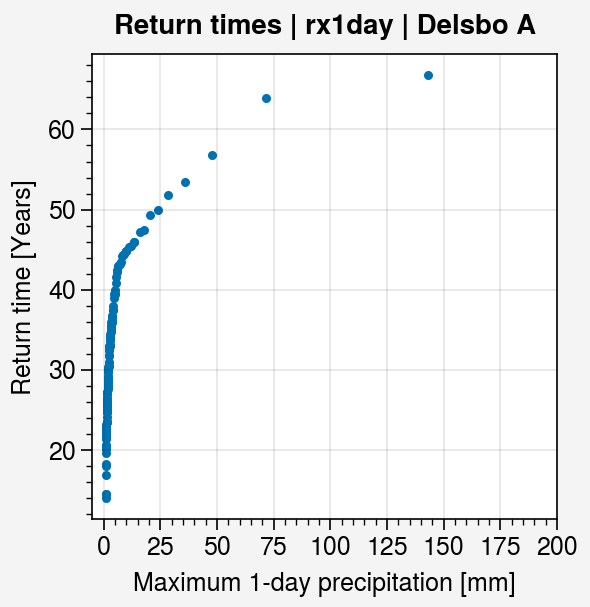

In [32]:
fig, ax = pplt.subplots(figwidth="7.5cm")
ax.scatter(143 / rank, index_cubes[0].data, s=7)
ax.format(
    xlabel=f"{index_cubes[0].long_name} [{index_cubes[0].units}]",
    ylabel="Return time [Years]",
    xlim=(-5, 200),
    xticks=25,
    yticks=10,
    suptitle=f"Return times | {index_name} | {index_cubes[0].attributes['station_name']}",
)

In [91]:
fig.save("./figs/test.pdf")

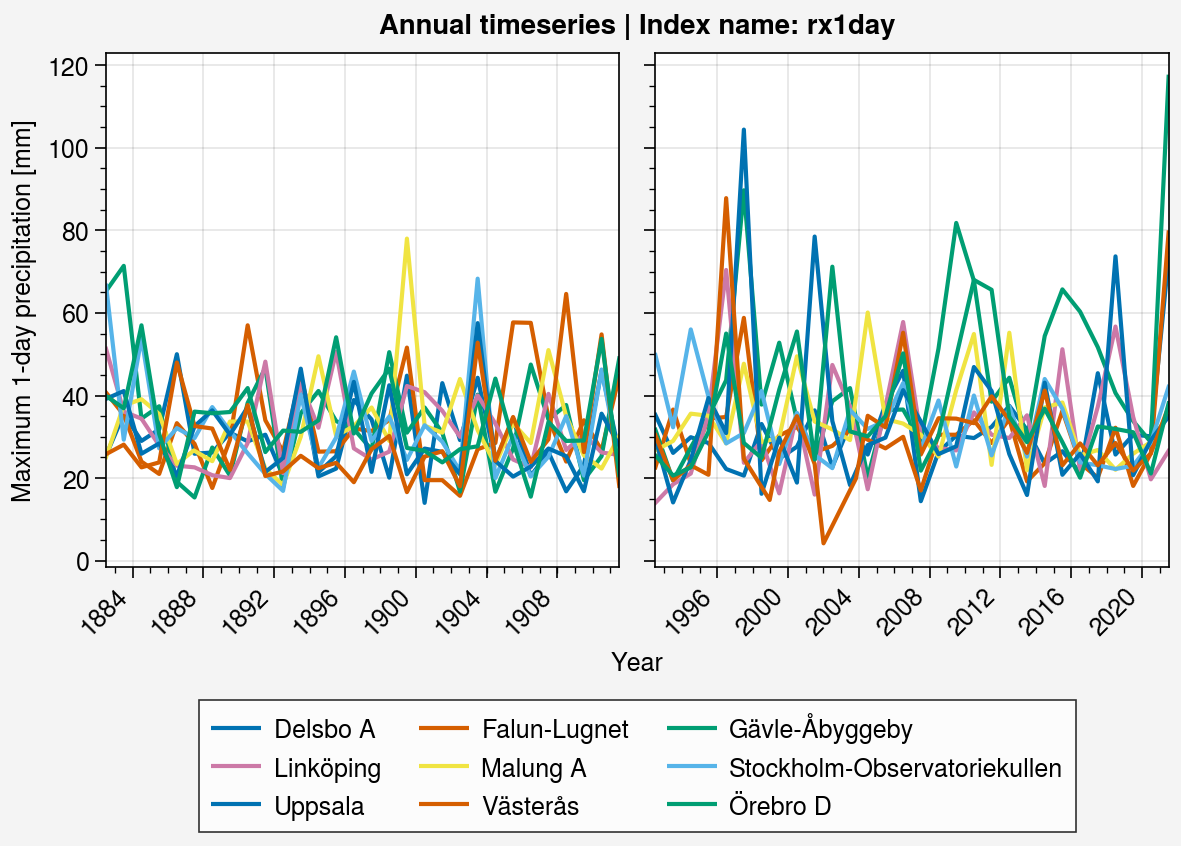

In [99]:
fig, axs = pplt.subplots(ncols=2, figwidth="15cm")
for hist_cube, curr_cube in zip(hist_cubes, curr_cubes):
    iplt.plot(hist_cube, axes=axs[0], label=hist_cube.attributes["station_name"])
    iplt.plot(curr_cube, axes=axs[1], label=curr_cube.attributes["station_name"])
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, ncol=3, loc="b")
ylabel = f"{hist_cube.long_name} [{hist_cube.units}]"
axs.format(
    xlabel="Year",
    ylabel=ylabel,
    suptitle=f"Annual timeseries | Index name: {index_name}",
    xrotation=45,
)

## Validating distributions

In [115]:
dists = {"gumbel_r": stats.gumbel_r, "gev": stats.genextreme}

In [160]:
import attribution

{'gumbel_r': KstestResult(statistic=0.21338198318178148, pvalue=0.11189266605413661),
 'gev': KstestResult(statistic=0.1528072008411863, pvalue=0.4416744228197369)}

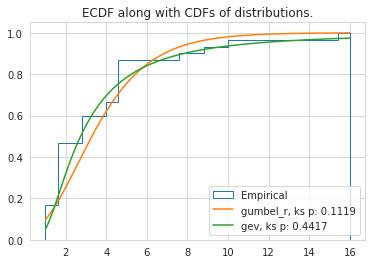

In [255]:
attribution.validation.inspect_distributions(hist_cubes[2].data, dists)

{'gumbel_r': KstestResult(statistic=0.10958394501879654, pvalue=0.826019606500246),
 'gev': KstestResult(statistic=0.12700338086131457, pvalue=0.671852069746989)}

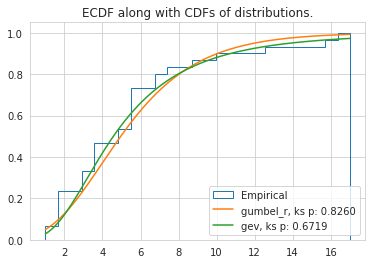

In [256]:
attribution.validation.inspect_distributions(curr_cubes[2].data, dists)

In [257]:
hist_fit = dists["gev"].fit(hist_cubes[2].data)
curr_fit = dists["gev"].fit(curr_cubes[2].data)

Simple check on plausibility.
Lower threshold should not return a higher FAR compared to higher thresholds.

In [259]:
p0 = dists["gev"].sf(10, *hist_fit)
p1 = dists["gev"].sf(10, *curr_fit)
1 - (p0 / p1)

0.4655940729758945

## Compute FAR and plot distributions

In [41]:
def fit_dist(hist_data, curr_data, dist):
    hist_fit = dist.fit(hist_data)
    curr_fit = dist.fit(curr_data)
    return hist_fit, curr_fit


def get_far(hist_fit, curr_fit, threshold, dist):
    p0 = dist.sf(threshold, *hist_fit)
    p1 = dist.sf(threshold, *curr_fit)
    return 1 - (p0 / p1)

In [34]:
rng = np.random.default_rng()

Bootstrap

In [35]:
dists = {"gumbel_r": stats.gumbel_r, "gev": stats.genextreme}

In [36]:
from pathos.pools import ProcessPool as Pool
from functools import partial

In [37]:
def pool_helper(curr_data, hist_data, dist, threshold_quantile):
    # curr_dist = select_distribution(curr_data, dists)
    # hist_dist = select_distribution(hist_data, dists)
    hist_fit, curr_fit = fit_dist(hist_data, curr_data, dist)
    threshold = dist.isf(threshold_quantile, *curr_fit)
    res = get_far(hist_fit, curr_fit, threshold, dist)
    return res

In [48]:
n_stations = len(hist_cubes)
n_samples = 1000
dist = dists["gumbel_r"]
# Fix threshold_quantile to measure Gavle precipitation
gavle_data = curr_cubes[2].data
fit = dist.fit(gavle_data)
threshold_quantile = dist.sf(gavle_data[-1], *fit)

far_res = np.zeros((n_stations, n_samples))
for i, (hist_cube, curr_cube) in tqdm(
    enumerate(zip(hist_cubes, curr_cubes)), total=n_stations
):
    # dist = attribution.validation.select_distribution(curr_cube.data, dists)
    hist_data = hist_cube.data
    curr_data = curr_cube.data
    hist_resampled = rng.choice(hist_data, size=(n_samples, hist_data.shape[0]))
    curr_resampled = rng.choice(curr_data, size=(n_samples, hist_data.shape[0]))
    pool_helper_p =  partial(pool_helper, dist=dist, threshold_quantile=threshold_quantile)
    with Pool() as p:
        res = p.map(pool_helper_p, curr_resampled, hist_resampled)
    far_res[i] = res

  0%|          | 0/10 [00:00<?, ?it/s]

In [50]:
# Save bootstrap results.
labels = [cube.attributes["station_name"] for cube in hist_cubes]
df = pd.DataFrame(far_res, index=labels)
df.to_csv(f"./data/res/{index_name}_far_boot.csv")

In [51]:
far_ci_q = np.quantile(far_res, [0.05, 0.5, 0.95], axis=1).T

In [52]:
data = np.concatenate([cube.data for cube in hist_cubes + curr_cubes])
_, bins = np.histogram(data, bins=15)

In [53]:
threshold_name = "Gävle 2021"

In [54]:
import math

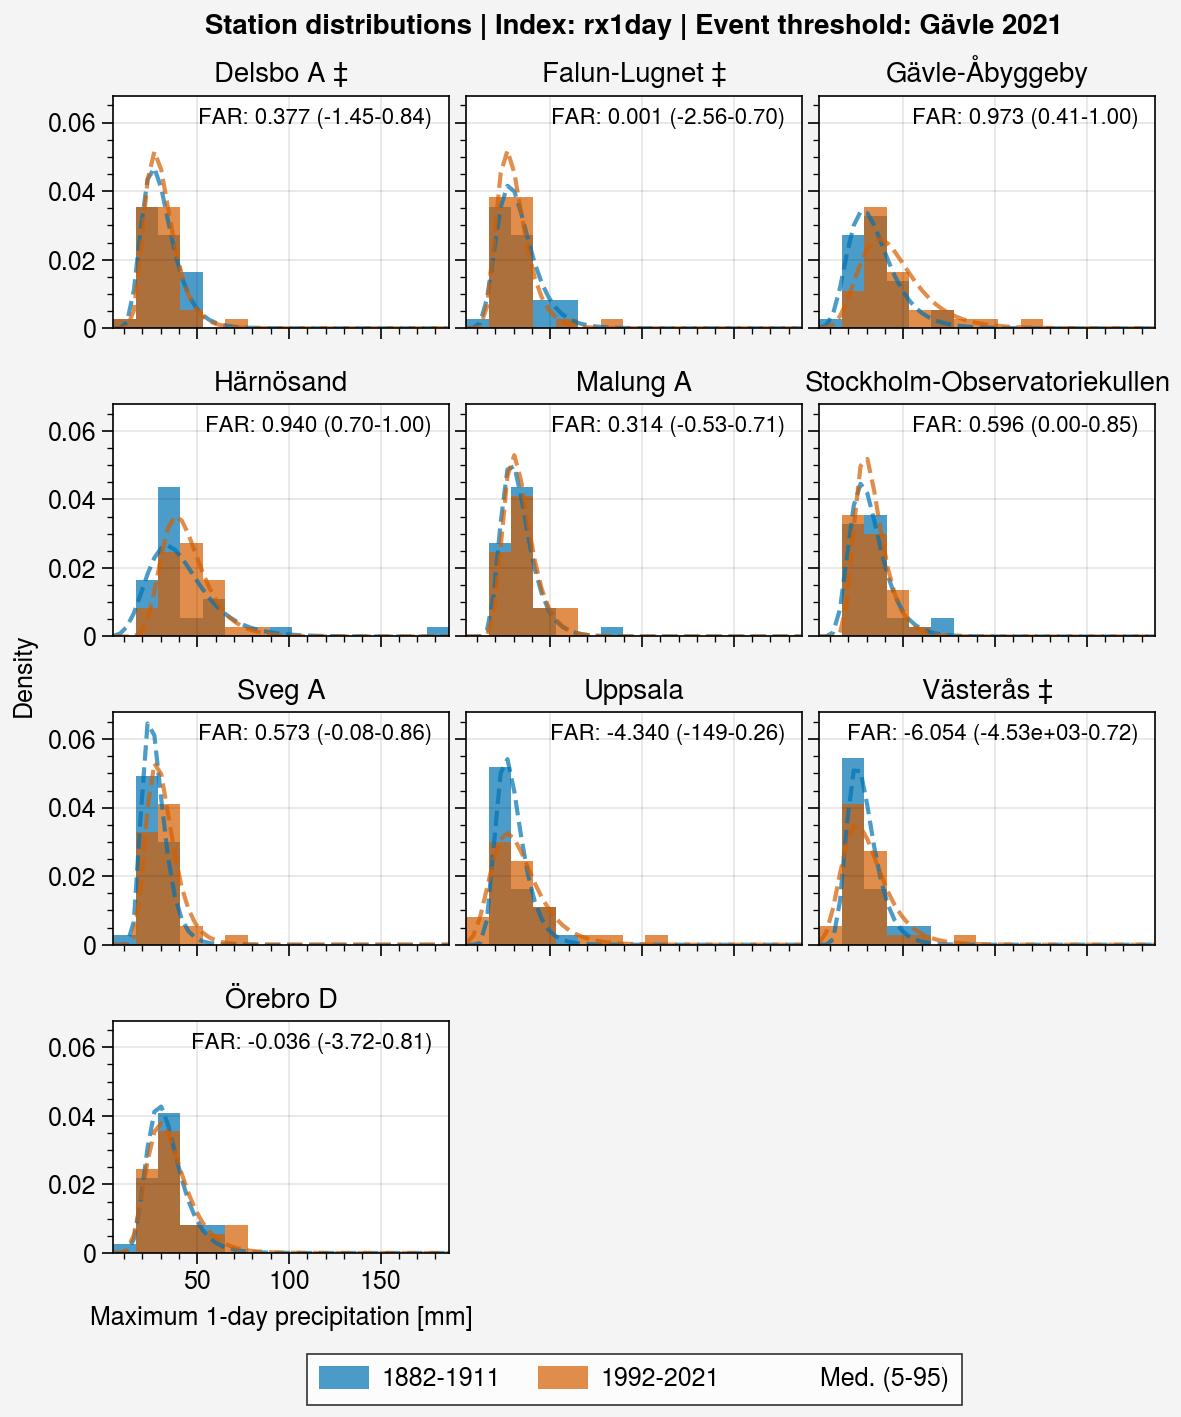

In [55]:
nrows = math.ceil(len(hist_cubes) / 3)
fig, axs = pplt.subplots(
    nrows=nrows, ncols=3, figwidth="15cm", figheight="18cm", wspace=0.7, sharex="all", sharey="all"
)
# axs_to_use = np.concatenate([axs.flat[:1], axs.flat[3:]])
axs_to_use = axs
for hist_cube, curr_cube, far_ci, ax in zip(
    hist_cubes, curr_cubes, far_ci_q, axs_to_use
):
    hist_data = hist_cube.data
    curr_data = curr_cube.data
    ax.hist(hist_data, bins=bins, label="1882-1911", alpha=0.7, density=True)
    ax.hist(curr_data, bins=bins, label="1992-2021", alpha=0.7, density=True)
    dist = dists["gumbel_r"]
    hist_fit, curr_fit = fit_dist(hist_data, curr_data, dist)
    x = np.linspace(bins.min(), bins.max())
    ax.plot(x, dist.pdf(x, *hist_fit), c="C0", alpha=0.7, ls="--")
    ax.plot(x, dist.pdf(x, *curr_fit), c="C1", alpha=0.7, ls="--")

    title = hist_cube.attributes["station_name"]
    hist_check, curr_check = check_station(title)
    if hist_check:
        title += " †"
    if curr_check:
        title += " ‡"
    #
    ax.set_title(title)
    format_string = ".3g" if far_ci[0] < -1e2 else ".2f"
    ax.annotate(
        f"FAR: {far_ci[1]:.3f} ({far_ci[0]:{format_string}}-{far_ci[2]:.2f})",
        (0.95, 0.95),
        xycoords="axes fraction",
        va="top",
        ha="right",
        fontsize=8,
    )

# axs.flat[1].axis("off")
# axs.flat[2].axis("off")


long_name = hist_cubes[0].long_name
unit = hist_cubes[0].units
# Legend
axs[0].plot([], [], " ", label="Med. (5-95)")
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, ncols=4, loc="b")
axs.format(
    ylabel="Density",
    xlabel=f"{long_name} [{unit}]",
    suptitle=f"Station distributions | Index: {index_name} | Event threshold: {threshold_name}",
)
axs[-2].set_visible(False)
axs[-1].set_visible(False)

In [56]:
fig.save(f"../plots/{index_name}_station_distributions_far.pdf")

## FAR bar plots

In [57]:
# Save bootstrap results.
labels = [cube.attributes["station_name"] for cube in hist_cubes]
df = pd.DataFrame(far_res, index=labels)
df.to_csv(f"./data/res/{index_name}_far_boot.csv")

In [58]:
labels = [cube.attributes["station_name"] for cube in hist_cubes]
far_ci = np.quantile(far_res, [0.05, 0.25, 0.5, 0.75, 0.95], axis=1).T

far_ci = np.concatenate([far_ci, far_ci.mean(axis=0, keepdims=True)])
labels += ["Average"]

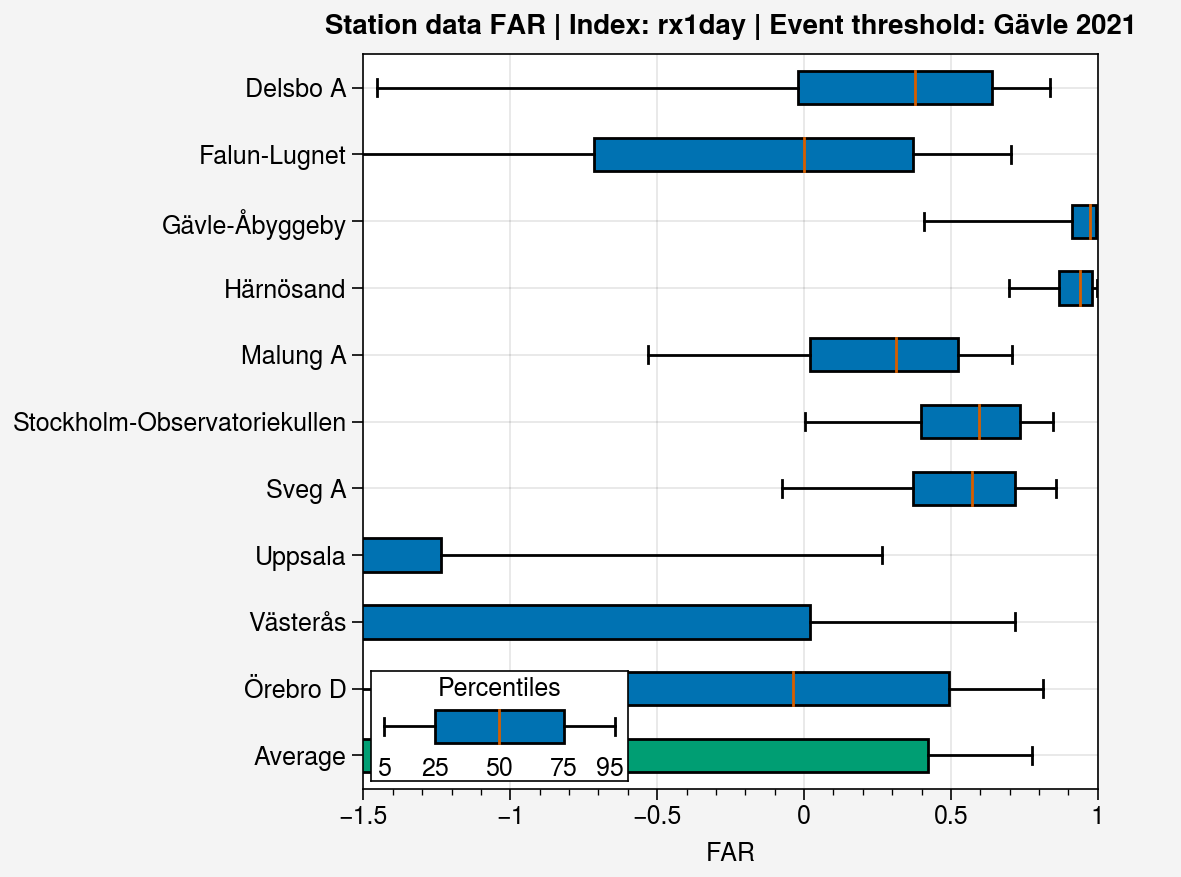

In [59]:
boxes = [
    {
        "label": label,
        "whislo": pbr[0],
        "q1": pbr[1],
        "med": pbr[2],
        "q3": pbr[3],
        "whishi": pbr[4],
        "fliers": None,
    }
    for pbr, label in zip(far_ci, labels)
]
fig, ax = pplt.subplots(
    figwidth="15cm",
)  # sharex="all", sharey="all")
patches = ax.bxp(boxes[::-1], vert=False, showfliers=False, patch_artist=True)
patches["boxes"][0].set_color("C2")
patches["boxes"][0].set_edgecolor("k")

axins = ax.inset_axes([0.01, 0.01, 0.35, 0.15], zoom=False)
# Dummy barplot
legend_box = {
    "label": None,
    "whislo": 5,
    "q1": 25,
    "med": 50,
    "q3": 75,
    "whishi": 95,
    "fliers": None,
}
axins.bxp(
    [
        legend_box,
    ],
    patch_artist=True,
    showfliers=False,
    vert=False,
    widths=0.3,
)
# Annotate percentiles.
axins.annotate("5", (5, 0.55), ha="center")
axins.annotate("25", (25, 0.55), ha="center")
axins.annotate("50", (50, 0.55), ha="center")
axins.annotate("75", (75, 0.55), ha="center")
axins.annotate("95", (93, 0.55), ha="center")
axins.annotate(
    "Percentiles", (0.5, 0.95), ha="center", va="top", xycoords="axes fraction"
)
axins.format(
    grid=False,
    xticklabelloc=None,
    xticklabels=[],
    xlim=(0, 100),
    xticks=False,
    yticks=False,
)

# axins.set_facecolor('none')

# Labels
ax.format(
    xlabel="FAR",
    suptitle=f"Station data FAR | Index: {index_name} | Event threshold: {threshold_name}",
    titleloc="r",
    xreverse=False,
    xlim=(-1.5, 1),
    ytickminor=False,
);

In [60]:
fig.save(f"../plots/{index_name}_station_bars_far.pdf")

## Trends?

In [44]:
import statsmodels.api as sm
import statsmodels.tsa as smt

/home/a002512/miniconda3/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
/home/a002512/miniconda3/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
/home/a002512/miniconda3/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
/home/a002512/miniconda3/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in th

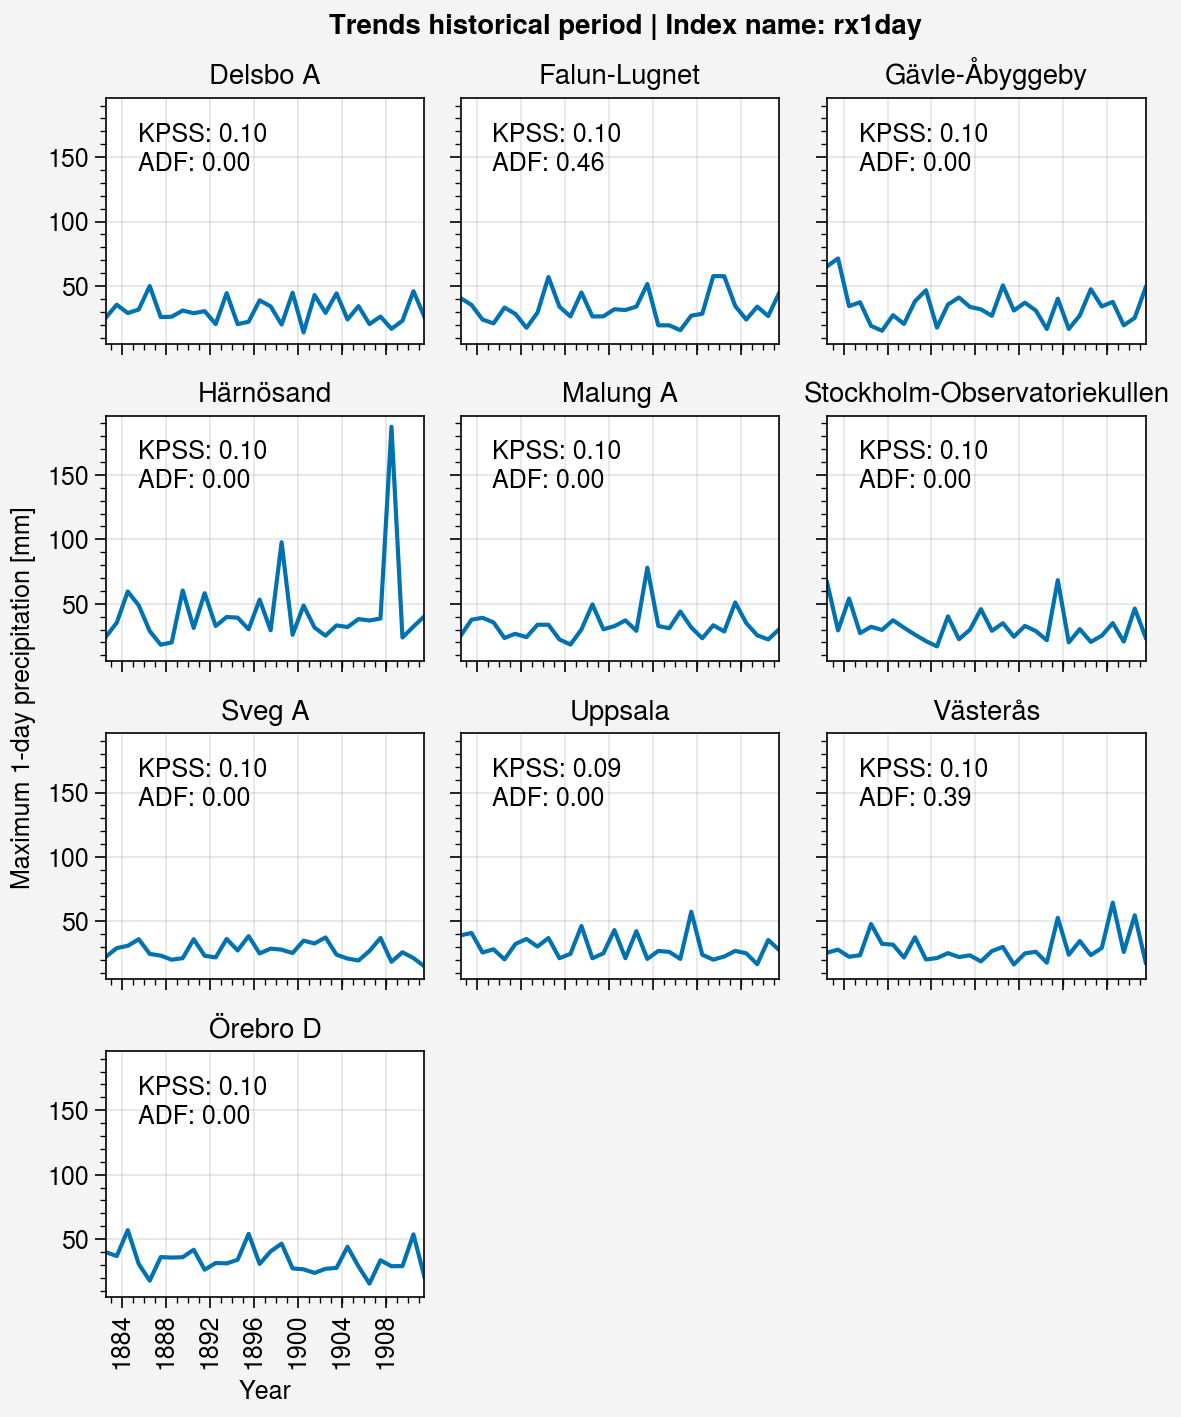

In [53]:
fig, axs = pplt.subplots(nrows=4, ncols=3, figwidth="15cm", figheight="18cm", share="all")
for ax, cube in zip(axs, hist_cubes):
    iplt.plot(cube, axes=ax, label=".");
    ax.format(title=cube.attributes["station_name"])
    
    kpss = smt.stattools.kpss(cube.data)
    adf = smt.stattools.adfuller(cube.data)
    ax.annotate(f"KPSS: {kpss[1]:.2f}\nADF: {adf[1]:.2f}", (0.1, 0.9), xycoords="axes fraction", ha="left", va="top")
axs[-2].set_visible(False)
axs[-1].set_visible(False)
long_name = hist_cubes[0].long_name
unit = hist_cubes[0].units
axs.format(xlabel="Year", ylabel=f"{long_name} [{unit}]")
fig.format(suptitle=f"Trends historical period | Index name: {index_name}")

In [54]:
fig.save(f"./figs/trend_hist_{index_name}.pdf")

INFO:distributed.utils_perf:full garbage collection released 24.41 MiB from 149896 reference cycles (threshold: 9.54 MiB)
/home/a002512/miniconda3/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
/home/a002512/miniconda3/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
/home/a002512/miniconda3/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
/home/a002512/miniconda3/lib/python3.10/site-packages/stats

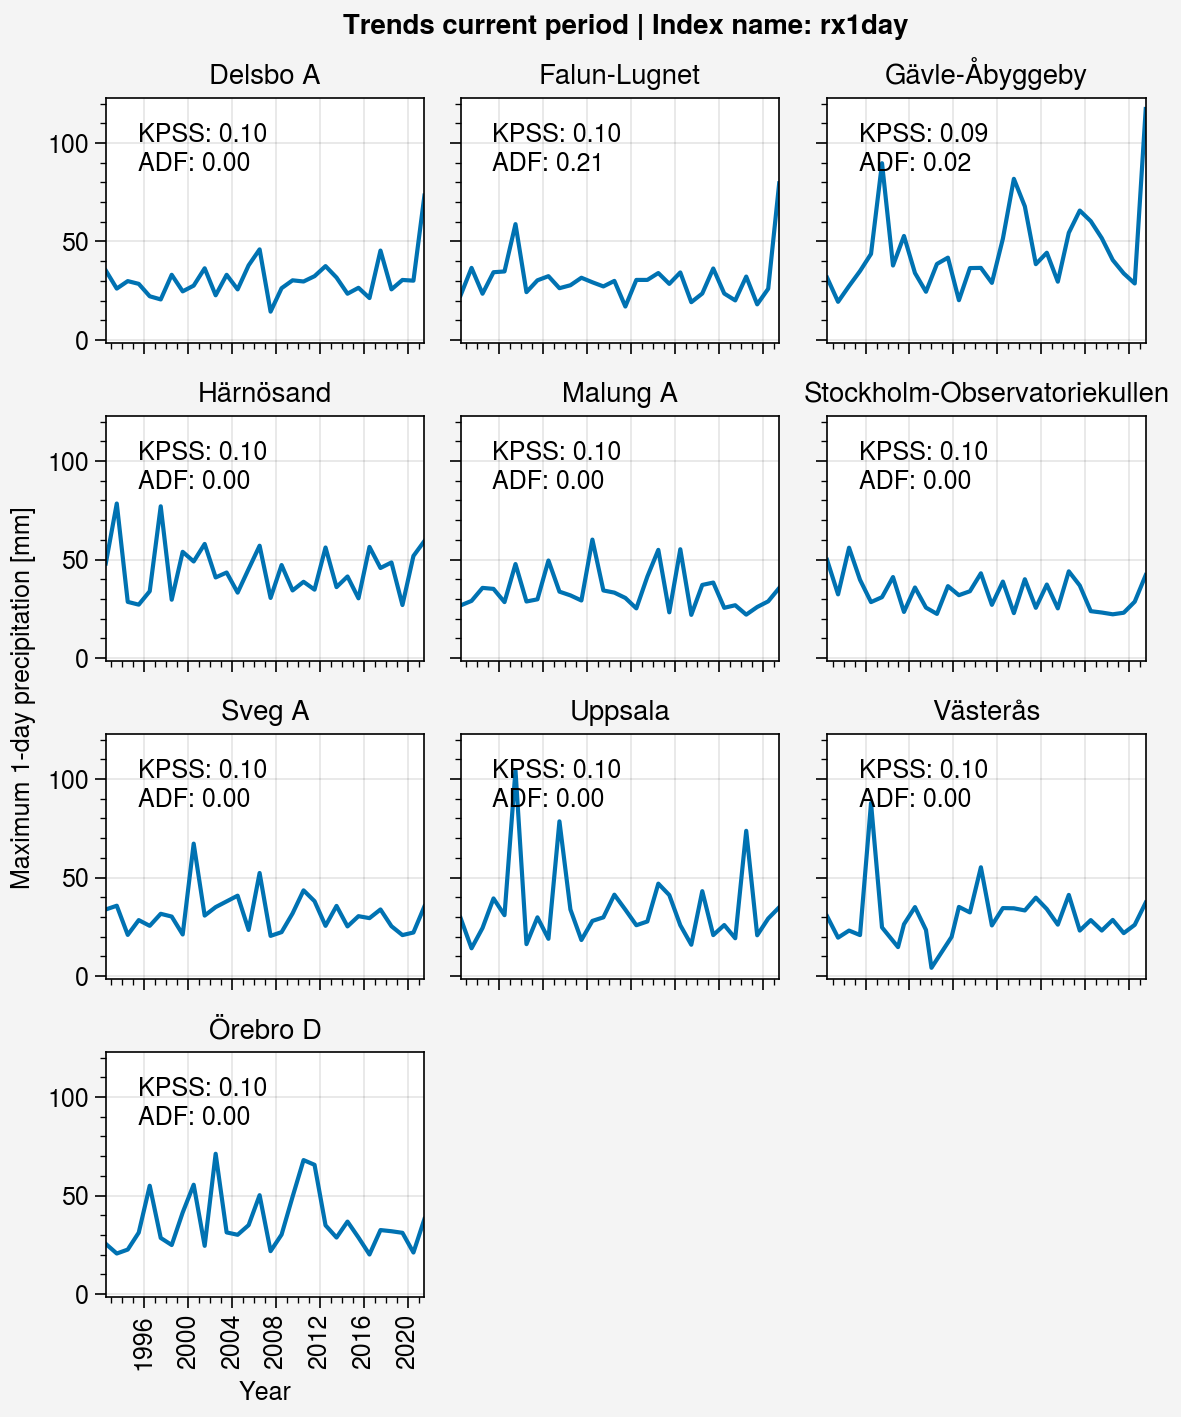

In [55]:
fig, axs = pplt.subplots(nrows=4, ncols=3, figwidth="15cm", figheight="18cm", share="all")
for ax, cube in zip(axs, curr_cubes):
    iplt.plot(cube, axes=ax, label=".");
    ax.format(title=cube.attributes["station_name"])
    
    kpss = smt.stattools.kpss(cube.data)
    adf = smt.stattools.adfuller(cube.data)
    ax.annotate(f"KPSS: {kpss[1]:.2f}\nADF: {adf[1]:.2f}", (0.1, 0.9), xycoords="axes fraction", ha="left", va="top")
axs[-2].set_visible(False)
axs[-1].set_visible(False)
long_name = hist_cubes[0].long_name
unit = hist_cubes[0].units
axs.format(xlabel="Year", ylabel=f"{long_name} [{unit}]")
fig.format(suptitle=f"Trends current period | Index name: {index_name}")

In [56]:
fig.save(f"./figs/trend_curr_{index_name}.pdf")